In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gpflow
import tensorflow.compat.v1 as tf
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

#models
#---------------------------------------------------------------
#---------------------------------------------------------------
def moving_average(data, window_size, n_forecast):
    return data.rolling(window = window_size).mean().iloc[-n_forecast:]

#---------------------------------------------------------------
def autoregression(data, start, end):
    res = AutoReg(data, lags = 1).fit()
    return res.model.predict(res.params, start = start, end = end)

#---------------------------------------------------------------
def simple_exponential_smoothing(data, n_forecast):
    model = SimpleExpSmoothing(data)
    model_fit = model.fit()
    return model_fit.forecast(n_forecast)

#---------------------------------------------------------------
def holtWinter_smoothing(data, n_forecast):
    model = ExponentialSmoothing(data)
    model_fit = model.fit()
    return model_fit.forecast(n_forecast)

#---------------------------------------------------------------
def arima_model(data, n_forecast):
    model = ARIMA(endog = data)
    model_fit = model.fit()
    return model_fit.forecast(steps = n_forecast)

#---------------------------------------------------------------
def linear_regression_model(Xtrain, ytrain, Xtest):
    
    model = LinearRegression()
    model.fit(Xtrain, ytrain)
    return model.predict(Xtest)

#---------------------------------------------------------------
def GPR(Xtrain, ytrain, Xtest):


    kernel = gpflow.kernels.RBF(lengthscales = 10)

    model = gpflow.models.SGPR(data = (Xtrain, ytrain), 
                               kernel = kernel, 
                               inducing_variable = Xtrain[::10])

    #opt = gpflow.optimizers.Scipy()
    opt = tf.optimizers.Adam()
    opt_logs = opt.minimize(model.training_loss, 
                            model.trainable_variables, 
                            options = dict(maxiter = 100))
    predictions, _ = model.predict_y(Xtest)
    return predictions

#---------------------------------------------------------------


In [3]:

df = pd.read_csv("52.75_Vandstand_Minut.csv", 
                        delimiter = ";", 
                        skiprows = 12,
                        encoding = "unicode-escape")

df=df.drop(columns=['ks mrk.'])
df=df.rename(columns={"Dato (DK normaltid)":"time", "Vandstand (m DVR90)":"level"})
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M')

df.set_index('time', inplace=True)
df.head()

,level
time,
2014-06-20 00:00:00,11.421
2014-06-20 00:15:00,11.421
2014-06-20 00:30:00,11.422
2014-06-20 00:45:00,11.422
2014-06-20 01:00:00,11.422


<Axes: title={'center': 'Water level Sengeløse '}, xlabel='time'>

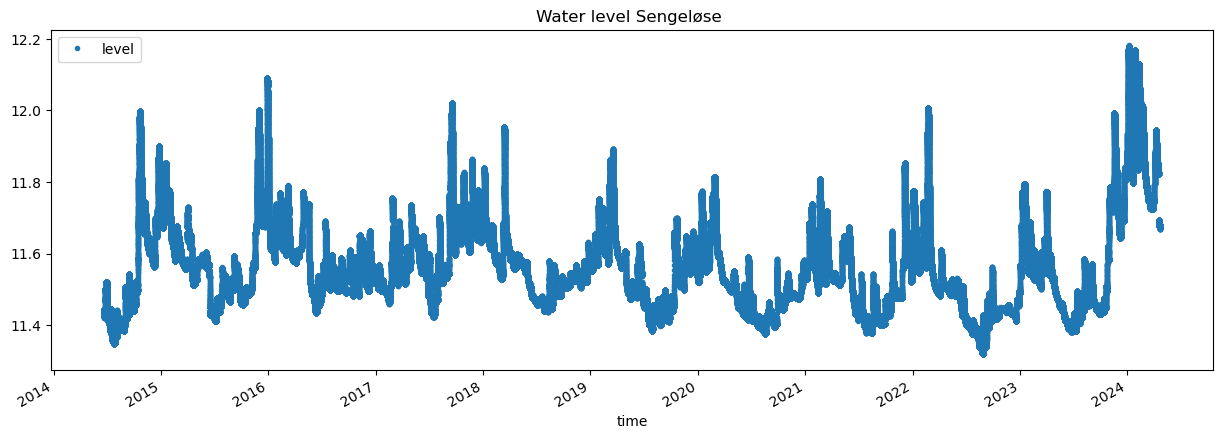

In [4]:
df.plot(style='.', figsize=(15, 5), title="Water level Sengeløse ")

In [5]:
#feature creation ideas

def create_features(df):
    
    df = df.copy()
    #df['hour'] = df.index.hour
    #df['dayofweek'] = df.index.dayofweek

    df['month'] = df.index.month

    #df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter

    #df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week 
    return df

df = create_features(df)

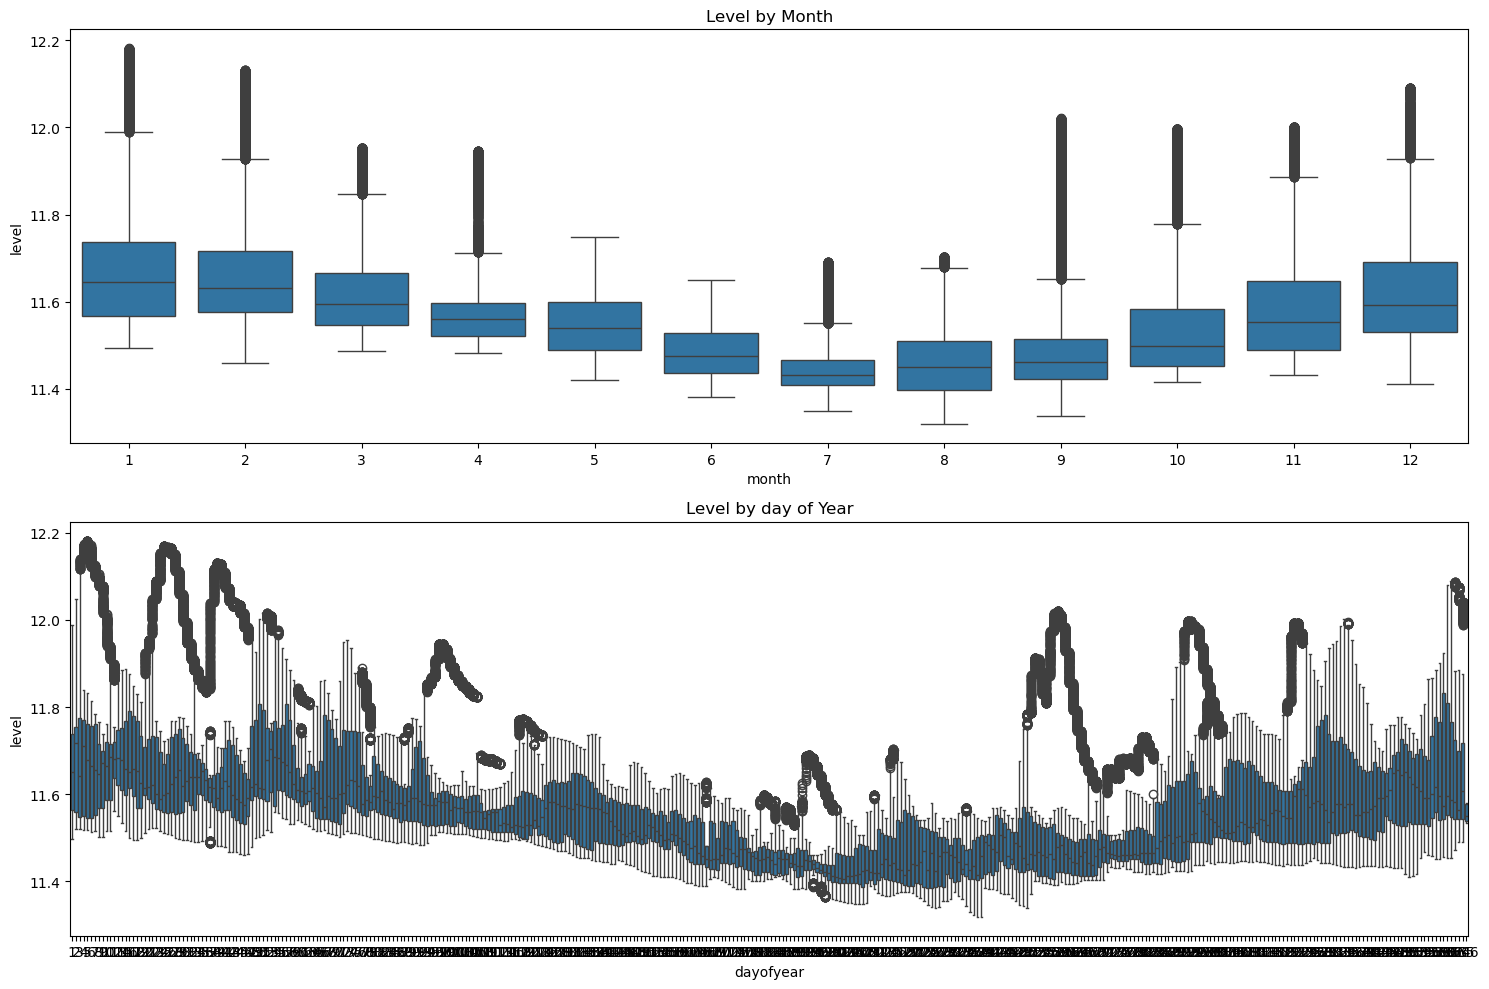

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data=df, x='month', y='level', ax=axs[0])
axs[0].set_title('Level by Month')

sns.boxplot(data=df, x='dayofyear', y='level', ax=axs[1])
axs[1].set_title('Level by day of Year')

plt.tight_layout()
plt.show()

In [18]:
#lag creation 

def add_lags(df):
    target_map = df['level'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df

df = add_lags(df)
lag_columns = ['lag1', 'lag2', 'lag3']

# Fill NaN values in each lag column with the first non-NaN value in that column
for col in lag_columns:
    first_value = df[col].dropna().iloc[0]  
    df[col].fillna(first_value, inplace=True)  

/var/folders/qr/zdl1jn496pg73658gxs99sxh0000gn/T/ipykernel_22293/3255357267.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(first_value, inplace=True)


In [ ]:
#sequential feature creation

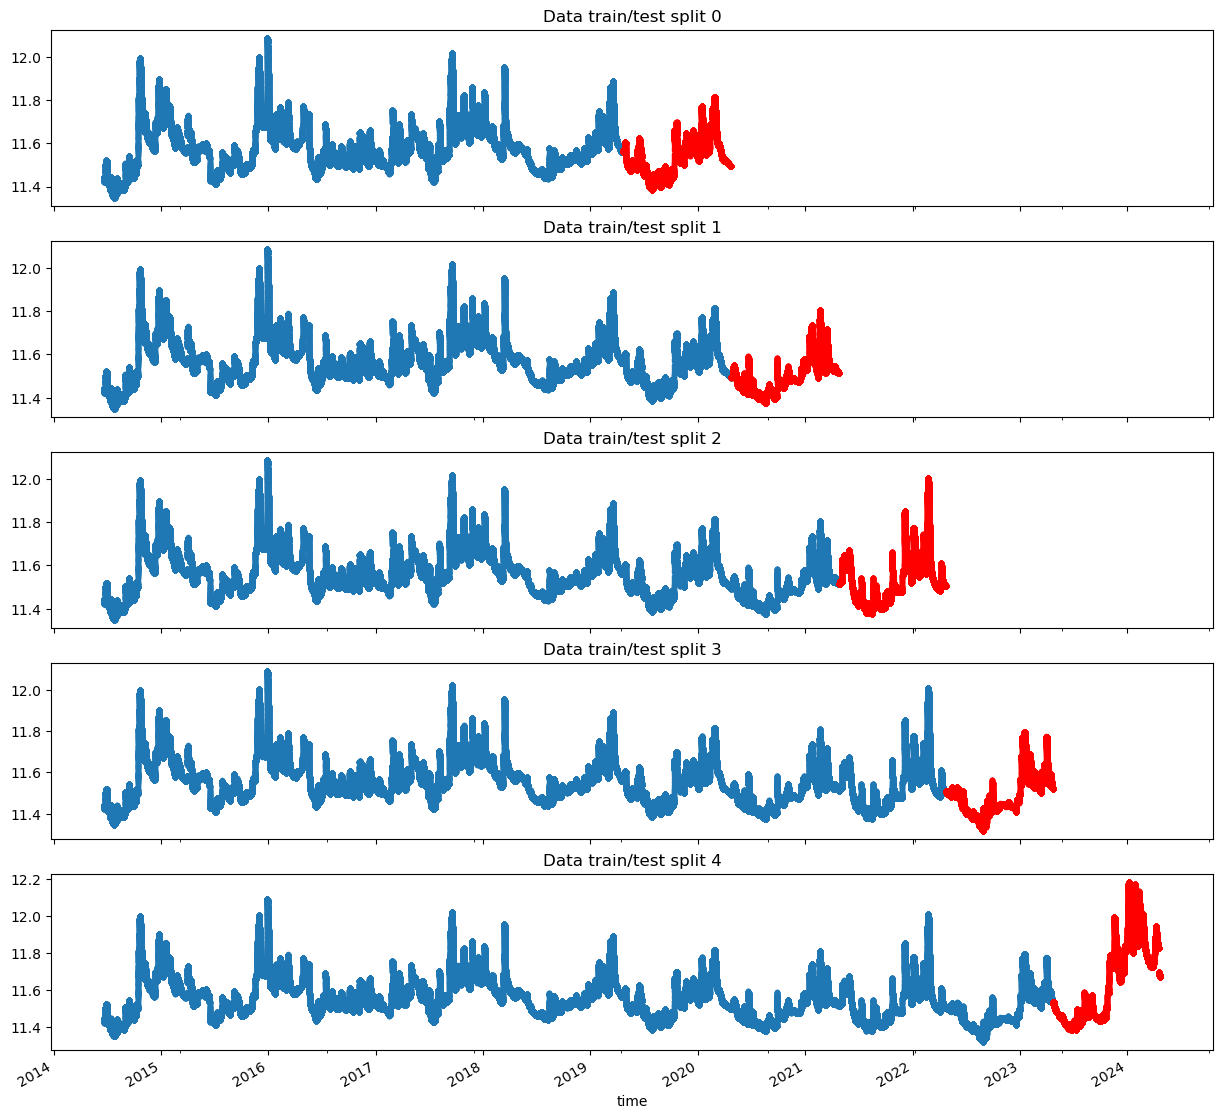

In [8]:
#cross validation

tss = TimeSeriesSplit(n_splits = 5, test_size=4*24*7*52, gap=24) # 1 years maybe
fold=0
fig, axs = plt.subplots(5, 1, figsize = (15,15),sharex = True) #, share_x = True
for train_index, test_index in tss.split(df):
    train=df.iloc[train_index]
    test=df.iloc[test_index]
    train["level"].plot(ax=axs[fold], style='.',title=f"Data train/test split {fold}")
    test["level"].plot(ax=axs[fold], style='.', color='red')
    fold+=1
plt.show()

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

In [21]:

tss = TimeSeriesSplit(n_splits=5, test_size=4*24*7*52, gap=24)  # 1 year maybe

r2_scores_mean = {}
predictions = {}

models = ["mavg", "areg", "simple", "exp", "arima", "linreg", "gpr", "xgb"]

for model in models:
    print("Model =", model)
    r2s = []
    
    last_forecast = None
    
    for train_idx, val_idx in tss.split(df):
        trainData = df.iloc[train_idx]
        testData = df.iloc[val_idx]
        
        ntest = testData.shape[0]
        Ytest = testData["level"].values

        if model in ["mavg", "areg", "simple", "exp", "arima"]:
            trainData = trainData["level"]  
            testData = testData["level"]
        else:
            Xtrain = trainData.drop(columns = "level")
            Ytrain = trainData["level"].values 
            Xtest = testData.drop(columns = "level")  
        if model == "mavg":
            forecast = moving_average(trainData, 10, ntest)
        elif model == "areg":
            forecast = autoregression(trainData, start=len(trainData), end=len(trainData) + ntest - 1)
        elif model == "simple":
            forecast = simple_exponential_smoothing(trainData, ntest)
        elif model == "exp":
            forecast = holtWinter_smoothing(trainData, ntest)
        #elif model == "arima":
           # forecast = arima_model(trainData, n_forecast=ntest)
        elif model == "linreg":
            forecast = linear_regression_model(Xtrain, Ytrain, Xtest)
        #elif model == "gpr":
           # forecast = GPR(Xtrain, Ytrain, Xtest)
        elif model == "xgb":
            reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
            reg.fit(Xtrain, Ytrain,
                eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)],
                verbose=0)        
            forecast = reg.predict(Xtest)

        r2 = r2_score(Ytest, forecast)
        r2s.append(r2)

        last_forecast = forecast
        
        print("R2 =", r2)

    r2_scores_mean[model] = np.mean(r2s)
    print("meanR2 =", r2_scores_mean[model])
    
    predictions[model] = {
        
        "forecast": last_forecast
    }


Model = mavg
R2 = 0.04615828737145533
R2 = 0.14408223895388284
R2 = 0.27806045339468843
R2 = -0.5039088268113372
R2 = -0.15545488923808004
meanR2 = -0.038212547265878125
Model = areg
R2 = -0.17095841014778657
R2 = 0.08296567235712637
R2 = 0.049353501919387366
R2 = -0.09176884340733027
R2 = -0.2001124370800611
meanR2 = -0.06610410327173284
Model = simple
R2 = -0.08530451878926648
R2 = -0.004313588813666502
R2 = -0.026475424398565428
R2 = -0.04977960920929414
R2 = -0.3076295552470194
meanR2 = -0.09470053929156239
Model = exp
R2 = -0.08530451878926648
R2 = -0.004313588813666502
R2 = -0.026475424398565428
R2 = -0.04977960920929414
R2 = -0.3076295552470194
meanR2 = -0.09470053929156239
Model = arima
R2 = -0.026145655250563893
R2 = -0.07914241480123252
R2 = -0.007271117550746498
R2 = -0.14538852824686344
R2 = -0.3076295552470194
meanR2 = -0.11311545421928515
Model = linreg
R2 = -0.2828714298745125
R2 = -1.0816434152573282
R2 = 0.12592380335870157
R2 = -0.15715058690684658
R2 = -0.04046632959

/Users/victor/anaconda3/envs/forecasting/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:04:27] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


R2 = 0.24913437034931807


/Users/victor/anaconda3/envs/forecasting/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:04:30] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


R2 = 0.3098576608611253


/Users/victor/anaconda3/envs/forecasting/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


R2 = 0.2926114856288513


/Users/victor/anaconda3/envs/forecasting/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:04:37] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


R2 = 0.3695427157803881


/Users/victor/anaconda3/envs/forecasting/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:04:40] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


R2 = 0.10578361333129316
meanR2 = 0.26538596919019514


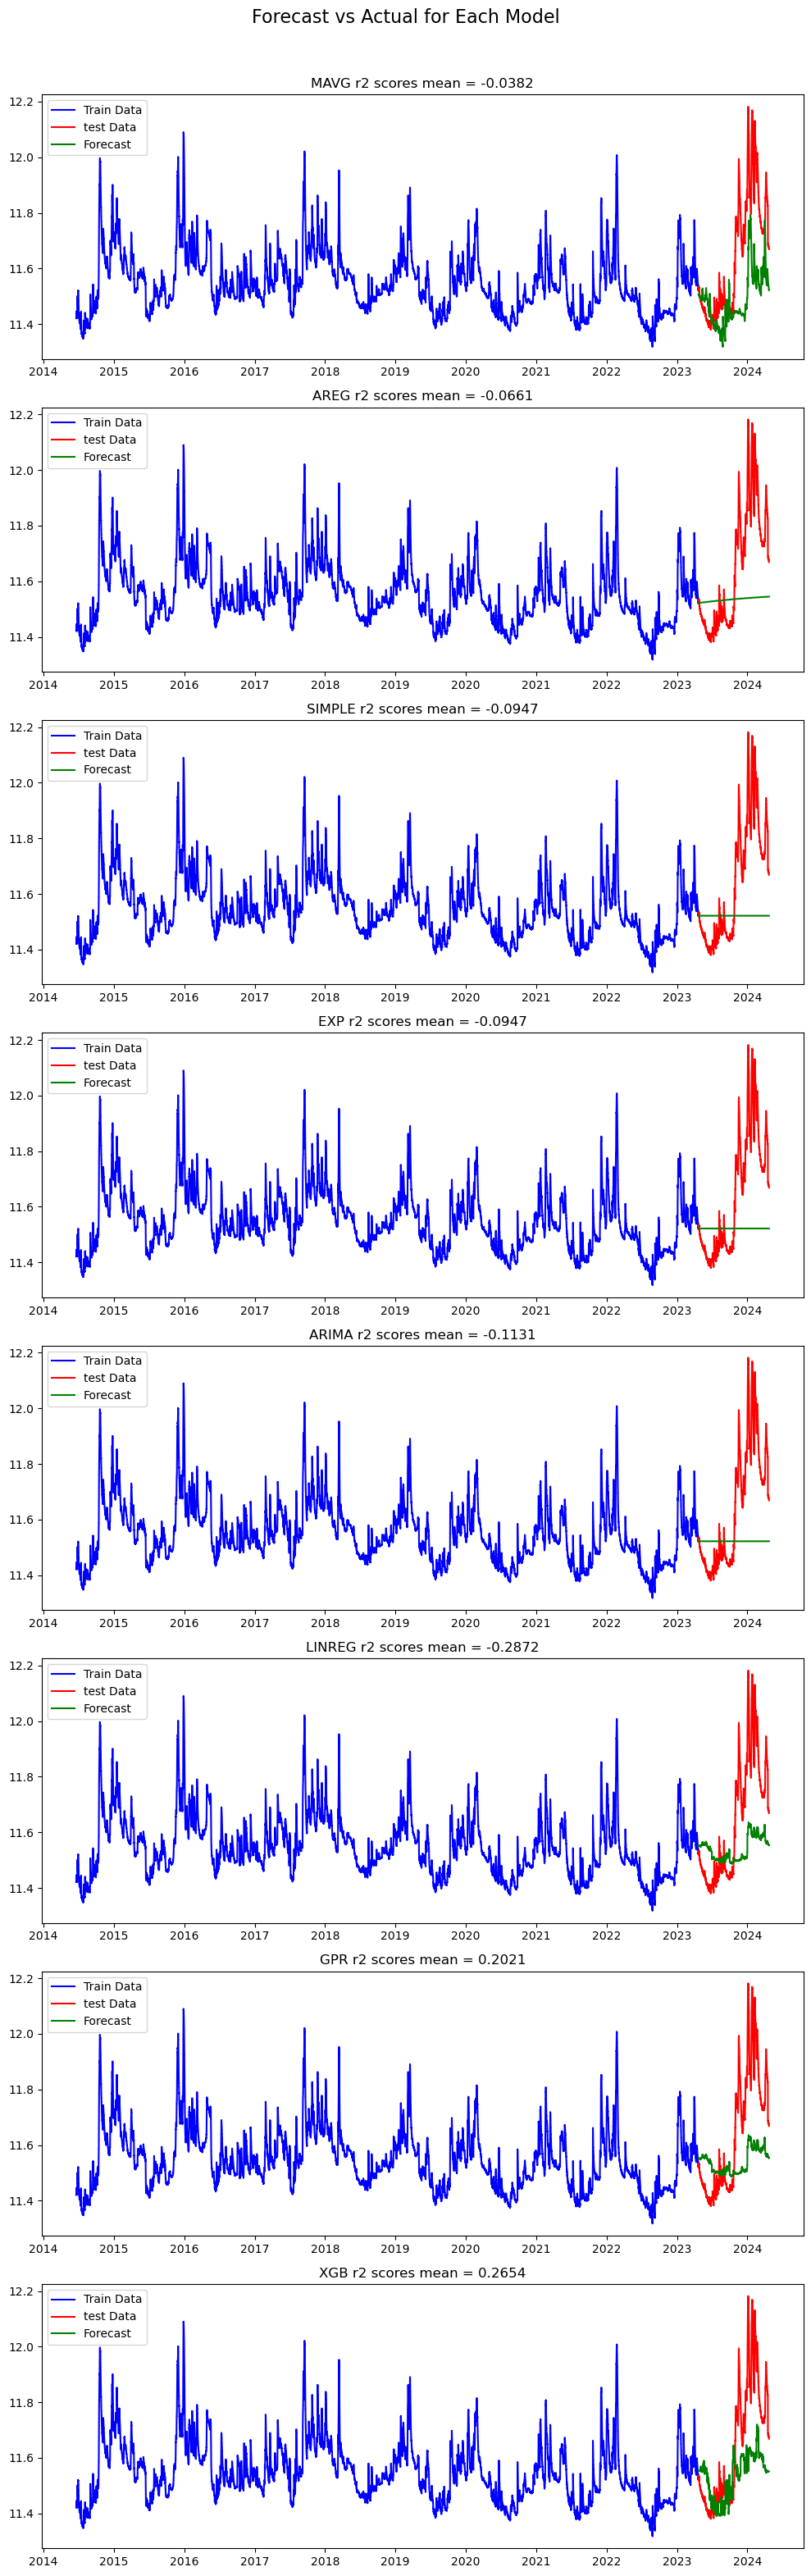

In [22]:
fig, axs = plt.subplots(len(models), 1, figsize=(10, len(models) * 4))
fig.suptitle('Forecast vs Actual for Each Model', fontsize=16)

for i, model in enumerate(models):
    ax = axs[i]
    ax.plot(trainData["level"], label="Train Data", color="blue")
    ax.plot(testData["level"], label="test Data", color="red")
    ax.plot(testData["level"].index, predictions[model]["forecast"], label="Forecast", color="green")
    
    ax.set_title(f"{model.upper() } r2 scores mean = {r2_scores_mean[model].round(4)}")
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()